In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import tensorflow as tf
SEED = 2
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# -------------------------------
# Parameters
# -------------------------------
IMG_SIZE = 48
NUM_CLASSES = 8
EPOCHS = 100
BATCH_SIZE = 128
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.01
DATA_DIR = '/content/drive/My Drive/ec523 project/data/affectnet'
#DATA_DIR = 'preprocessed_data'  # Folder containing X_train.npy, y_train.npy, X_val.npy, y_val.npy, X_test.npy, y_test.npy

# -------------------------------
# Load Preprocessed Data (Training, Validation & Test Sets)
# -------------------------------
def load_data(data_dir):
    #X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
    X_train = np.load(os.path.join(data_dir, 'X_train.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    X_val = np.load(os.path.join(data_dir, 'X_val.npy'))
    y_val = np.load(os.path.join(data_dir, 'y_val.npy'))
    X_test = np.load(os.path.join(data_dir, 'X_test.npy'))
    y_test = np.load(os.path.join(data_dir, 'y_test.npy'))
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_data(DATA_DIR)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (201347, 48, 48, 1) (201347, 8)
Validation set: (43155, 48, 48, 1) (43155, 8)
Test set: (43148, 48, 48, 1) (43148, 8)


In [3]:
# -------------------------------
# Build Model (Same Architecture as FER2013 Baseline)
# -------------------------------
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', name="conv1"),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu', padding='same', name="conv2"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), name="maxpool2"),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', padding='same', name="conv3"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), name="maxpool3"),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', padding='same', name="conv4"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), name="maxpool4"),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', padding='same', name="conv5"),
    BatchNormalization(),
    Dropout(0.3),
    Flatten(),
    Dense(1024, activation='relu', name='fc1'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax', name='fcsoftmax')
])

sgd = SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

# -------------------------------
# Set Up Callbacks
# -------------------------------
checkpoint = ModelCheckpoint("CNN_AffectNet_final_implement_model.h5", monitor='loss', verbose=1, save_best_only=True, mode='min')
#checkpoint = ModelCheckpoint("AffectNet_CNN_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
rlrop = ReduceLROnPlateau(monitor='loss', mode='min', factor=0.5, patience=10, min_lr=0.00001, verbose=1)
callbacks_list = [checkpoint, rlrop]

In [4]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    shuffle=True,
    validation_data=(X_val, y_val)
)

Epoch 1/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5415 - loss: 1.3751
Epoch 1: loss improved from inf to 1.18412, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 84s 49ms/step - accuracy: 0.5415 - loss: 1.3750 - val_accuracy: 0.6560 - val_loss: 0.9843 - learning_rate: 0.0100
Epoch 2/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6467 - loss: 1.0175
Epoch 2: loss improved from 1.18412 to 0.98629, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.6467 - loss: 1.0175 - val_accuracy: 0.6779 - val_loss: 0.9321 - learning_rate: 0.0100
Epoch 3/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6746 - loss: 0.9337
Epoch 3: loss improved from 0.98629 to 0.92332, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.6747 - loss: 0.9337 - val_accuracy: 0.6991 - val_loss: 0.8534 - learning_rate: 0.0100
Epoch 4/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6897 - loss: 0.8899
Epoch 4: loss improved from 0.92332 to 0.88482, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.6897 - loss: 0.8899 - val_accuracy: 0.7069 - val_loss: 0.8311 - learning_rate: 0.0100
Epoch 5/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6980 - loss: 0.8670
Epoch 5: loss improved from 0.88482 to 0.86324, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.6980 - loss: 0.8670 - val_accuracy: 0.7111 - val_loss: 0.8286 - learning_rate: 0.0100
Epoch 6/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7025 - loss: 0.8503
Epoch 6: loss improved from 0.86324 to 0.84623, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7025 - loss: 0.8503 - val_accuracy: 0.7178 - val_loss: 0.8002 - learning_rate: 0.0100
Epoch 7/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7099 - loss: 0.8296
Epoch 7: loss improved from 0.84623 to 0.82892, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.7099 - loss: 0.8296 - val_accuracy: 0.7198 - val_loss: 0.7946 - learning_rate: 0.0100
Epoch 8/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7142 - loss: 0.8174
Epoch 8: loss improved from 0.82892 to 0.81630, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7142 - loss: 0.8174 - val_accuracy: 0.7251 - val_loss: 0.7762 - learning_rate: 0.0100
Epoch 9/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7180 - loss: 0.8011
Epoch 9: loss improved from 0.81630 to 0.80254, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7180 - loss: 0.8011 - val_accuracy: 0.7243 - val_loss: 0.7823 - learning_rate: 0.0100
Epoch 10/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7170 - loss: 0.8036
Epoch 10: loss improved from 0.80254 to 0.79805, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7170 - loss: 0.8036 - val_accuracy: 0.7321 - val_loss: 0.7575 - learning_rate: 0.0100
Epoch 11/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7242 - loss: 0.7844
Epoch 11: loss improved from 0.79805 to 0.78513, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - accuracy: 0.7242 - loss: 0.7844 - val_accuracy: 0.7330 - val_loss: 0.7607 - learning_rate: 0.0100
Epoch 12/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7282 - loss: 0.7715
Epoch 12: loss improved from 0.78513 to 0.77321, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7282 - loss: 0.7715 - val_accuracy: 0.7344 - val_loss: 0.7539 - learning_rate: 0.0100
Epoch 13/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7301 - loss: 0.7637
Epoch 13: loss improved from 0.77321 to 0.76523, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.7301 - loss: 0.7637 - val_accuracy: 0.7338 - val_loss: 0.7536 - learning_rate: 0.0100
Epoch 14/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7324 - loss: 0.7585
Epoch 14: loss improved from 0.76523 to 0.75765, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.7324 - loss: 0.7585 - val_accuracy: 0.7341 - val_loss: 0.7556 - learning_rate: 0.0100
Epoch 15/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7356 - loss: 0.7479
Epoch 15: loss improved from 0.75765 to 0.74939, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7356 - loss: 0.7479 - val_accuracy: 0.7350 - val_loss: 0.7563 - learning_rate: 0.0100
Epoch 16/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7374 - loss: 0.7402
Epoch 16: loss improved from 0.74939 to 0.74171, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.7374 - loss: 0.7402 - val_accuracy: 0.7383 - val_loss: 0.7488 - learning_rate: 0.0100
Epoch 17/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7387 - loss: 0.7349
Epoch 17: loss improved from 0.74171 to 0.73625, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7387 - loss: 0.7349 - val_accuracy: 0.7369 - val_loss: 0.7518 - learning_rate: 0.0100
Epoch 18/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7419 - loss: 0.7262
Epoch 18: loss improved from 0.73625 to 0.72737, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7419 - loss: 0.7262 - val_accuracy: 0.7362 - val_loss: 0.7551 - learning_rate: 0.0100
Epoch 19/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7425 - loss: 0.7226
Epoch 19: loss improved from 0.72737 to 0.72239, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7425 - loss: 0.7226 - val_accuracy: 0.7393 - val_loss: 0.7518 - learning_rate: 0.0100
Epoch 20/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7457 - loss: 0.7128
Epoch 20: loss improved from 0.72239 to 0.71469, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.7457 - loss: 0.7128 - val_accuracy: 0.7385 - val_loss: 0.7497 - learning_rate: 0.0100
Epoch 21/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7473 - loss: 0.7093
Epoch 21: loss improved from 0.71469 to 0.70922, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7473 - loss: 0.7093 - val_accuracy: 0.7401 - val_loss: 0.7461 - learning_rate: 0.0100
Epoch 22/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7484 - loss: 0.7039
Epoch 22: loss improved from 0.70922 to 0.70492, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7484 - loss: 0.7039 - val_accuracy: 0.7364 - val_loss: 0.7520 - learning_rate: 0.0100
Epoch 23/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7517 - loss: 0.6942
Epoch 23: loss improved from 0.70492 to 0.69614, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7517 - loss: 0.6942 - val_accuracy: 0.7365 - val_loss: 0.7531 - learning_rate: 0.0100
Epoch 24/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7521 - loss: 0.6948
Epoch 24: loss improved from 0.69614 to 0.69292, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7521 - loss: 0.6948 - val_accuracy: 0.7412 - val_loss: 0.7472 - learning_rate: 0.0100
Epoch 25/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7551 - loss: 0.6868
Epoch 25: loss improved from 0.69292 to 0.68608, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.7551 - loss: 0.6868 - val_accuracy: 0.7401 - val_loss: 0.7459 - learning_rate: 0.0100
Epoch 26/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7583 - loss: 0.6762
Epoch 26: loss improved from 0.68608 to 0.67593, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.7583 - loss: 0.6762 - val_accuracy: 0.7392 - val_loss: 0.7491 - learning_rate: 0.0100
Epoch 27/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7607 - loss: 0.6683
Epoch 27: loss improved from 0.67593 to 0.67117, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.7607 - loss: 0.6683 - val_accuracy: 0.7403 - val_loss: 0.7523 - learning_rate: 0.0100
Epoch 28/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7613 - loss: 0.6626
Epoch 28: loss improved from 0.67117 to 0.66360, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.7613 - loss: 0.6626 - val_accuracy: 0.7399 - val_loss: 0.7495 - learning_rate: 0.0100
Epoch 29/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7616 - loss: 0.6610
Epoch 29: loss improved from 0.66360 to 0.66051, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.7616 - loss: 0.6610 - val_accuracy: 0.7381 - val_loss: 0.7532 - learning_rate: 0.0100
Epoch 30/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7649 - loss: 0.6508
Epoch 30: loss improved from 0.66051 to 0.65226, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.7649 - loss: 0.6508 - val_accuracy: 0.7395 - val_loss: 0.7537 - learning_rate: 0.0100
Epoch 31/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7684 - loss: 0.6432
Epoch 31: loss improved from 0.65226 to 0.64643, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.7684 - loss: 0.6432 - val_accuracy: 0.7391 - val_loss: 0.7597 - learning_rate: 0.0100
Epoch 32/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7691 - loss: 0.6434
Epoch 32: loss improved from 0.64643 to 0.64274, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7690 - loss: 0.6434 - val_accuracy: 0.7353 - val_loss: 0.7725 - learning_rate: 0.0100
Epoch 33/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7637 - loss: 0.6583
Epoch 33: loss did not improve from 0.64274
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7637 - loss: 0.6583 - val_accuracy: 0.7415 - val_loss: 0.7554 - learning_rate: 0.0100
Epoch 34/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7713 - loss: 0.6316
Epoch 34: loss improved from 0.64274 to 0.63058, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7713 - loss: 0.6316 - val_accuracy: 0.7418 - val_loss: 0.7551 - learning_rate: 0.0100
Epoch 35/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7724 - loss: 0.6245
Epoch 35: loss improved from 0.63058 to 0.62456, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7724 - loss: 0.6245 - val_accuracy: 0.7402 - val_loss: 0.7602 - learning_rate: 0.0100
Epoch 36/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7763 - loss: 0.6179
Epoch 36: loss improved from 0.62456 to 0.61815, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.7763 - loss: 0.6179 - val_accuracy: 0.7410 - val_loss: 0.7572 - learning_rate: 0.0100
Epoch 37/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7770 - loss: 0.6142
Epoch 37: loss improved from 0.61815 to 0.61359, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.7770 - loss: 0.6142 - val_accuracy: 0.7404 - val_loss: 0.7596 - learning_rate: 0.0100
Epoch 38/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7793 - loss: 0.6078
Epoch 38: loss improved from 0.61359 to 0.60769, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7793 - loss: 0.6078 - val_accuracy: 0.7386 - val_loss: 0.7704 - learning_rate: 0.0100
Epoch 39/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7802 - loss: 0.6020
Epoch 39: loss improved from 0.60769 to 0.60095, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.7802 - loss: 0.6020 - val_accuracy: 0.7429 - val_loss: 0.7594 - learning_rate: 0.0100
Epoch 40/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7841 - loss: 0.5973
Epoch 40: loss improved from 0.60095 to 0.59817, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7841 - loss: 0.5973 - val_accuracy: 0.7401 - val_loss: 0.7643 - learning_rate: 0.0100
Epoch 41/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7843 - loss: 0.5893
Epoch 41: loss improved from 0.59817 to 0.59019, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7843 - loss: 0.5893 - val_accuracy: 0.7363 - val_loss: 0.7766 - learning_rate: 0.0100
Epoch 42/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7809 - loss: 0.6022
Epoch 42: loss did not improve from 0.59019
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.7809 - loss: 0.6022 - val_accuracy: 0.7404 - val_loss: 0.7693 - learning_rate: 0.0100
Epoch 43/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7889 - loss: 0.5807
Epoch 43: loss improved from 0.59019 to 0.57949, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - accuracy: 0.7889 - loss: 0.5807 - val_accuracy: 0.7388 - val_loss: 0.7721 - learning_rate: 0.0100
Epoch 44/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7889 - loss: 0.5759
Epoch 44: loss improved from 0.57949 to 0.57590, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.7889 - loss: 0.5759 - val_accuracy: 0.7399 - val_loss: 0.7701 - learning_rate: 0.0100
Epoch 45/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7901 - loss: 0.5691
Epoch 45: loss improved from 0.57590 to 0.56939, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.7901 - loss: 0.5691 - val_accuracy: 0.7379 - val_loss: 0.7816 - learning_rate: 0.0100
Epoch 46/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7943 - loss: 0.5648
Epoch 46: loss improved from 0.56939 to 0.56295, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 79s 47ms/step - accuracy: 0.7943 - loss: 0.5648 - val_accuracy: 0.7404 - val_loss: 0.7744 - learning_rate: 0.0100
Epoch 47/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7951 - loss: 0.5574
Epoch 47: loss improved from 0.56295 to 0.55774, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.7952 - loss: 0.5574 - val_accuracy: 0.7398 - val_loss: 0.7809 - learning_rate: 0.0100
Epoch 48/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7964 - loss: 0.5526
Epoch 48: loss improved from 0.55774 to 0.55223, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.7964 - loss: 0.5526 - val_accuracy: 0.7392 - val_loss: 0.7828 - learning_rate: 0.0100
Epoch 49/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7985 - loss: 0.5486
Epoch 49: loss improved from 0.55223 to 0.54873, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.7985 - loss: 0.5486 - val_accuracy: 0.7401 - val_loss: 0.7857 - learning_rate: 0.0100
Epoch 50/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7996 - loss: 0.5436
Epoch 50: loss improved from 0.54873 to 0.54386, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.7996 - loss: 0.5436 - val_accuracy: 0.7391 - val_loss: 0.7847 - learning_rate: 0.0100
Epoch 51/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8010 - loss: 0.5414
Epoch 51: loss improved from 0.54386 to 0.54037, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.8010 - loss: 0.5414 - val_accuracy: 0.7401 - val_loss: 0.7867 - learning_rate: 0.0100
Epoch 52/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8023 - loss: 0.5382
Epoch 52: loss improved from 0.54037 to 0.53623, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.8023 - loss: 0.5382 - val_accuracy: 0.7397 - val_loss: 0.7868 - learning_rate: 0.0100
Epoch 53/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8059 - loss: 0.5269
Epoch 53: loss improved from 0.53623 to 0.52849, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 84s 48ms/step - accuracy: 0.8059 - loss: 0.5269 - val_accuracy: 0.7377 - val_loss: 0.7944 - learning_rate: 0.0100
Epoch 54/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8065 - loss: 0.5258
Epoch 54: loss improved from 0.52849 to 0.52370, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8065 - loss: 0.5258 - val_accuracy: 0.7360 - val_loss: 0.8114 - learning_rate: 0.0100
Epoch 55/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8104 - loss: 0.5187
Epoch 55: loss improved from 0.52370 to 0.51879, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.8104 - loss: 0.5187 - val_accuracy: 0.7387 - val_loss: 0.7976 - learning_rate: 0.0100
Epoch 56/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8106 - loss: 0.5159
Epoch 56: loss improved from 0.51879 to 0.51596, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8106 - loss: 0.5159 - val_accuracy: 0.7380 - val_loss: 0.8086 - learning_rate: 0.0100
Epoch 57/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8107 - loss: 0.5125
Epoch 57: loss improved from 0.51596 to 0.51238, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8107 - loss: 0.5125 - val_accuracy: 0.7383 - val_loss: 0.8046 - learning_rate: 0.0100
Epoch 58/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8122 - loss: 0.5067
Epoch 58: loss improved from 0.51238 to 0.50750, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.8122 - loss: 0.5067 - val_accuracy: 0.7367 - val_loss: 0.8124 - learning_rate: 0.0100
Epoch 59/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8114 - loss: 0.5143
Epoch 59: loss did not improve from 0.50750
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.8114 - loss: 0.5143 - val_accuracy: 0.7378 - val_loss: 0.8134 - learning_rate: 0.0100
Epoch 60/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8117 - loss: 0.5094
Epoch 60: loss improved from 0.50750 to 0.50521, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8117 - loss: 0.5094 - val_accuracy: 0.7403 - val_loss: 0.8143 - learning_rate: 0.0100
Epoch 61/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8163 - loss: 0.4986
Epoch 61: loss improved from 0.50521 to 0.49871, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.8163 - loss: 0.4986 - val_accuracy: 0.7364 - val_loss: 0.8173 - learning_rate: 0.0100
Epoch 62/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8178 - loss: 0.4942
Epoch 62: loss improved from 0.49871 to 0.49489, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.8178 - loss: 0.4942 - val_accuracy: 0.7356 - val_loss: 0.8252 - learning_rate: 0.0100
Epoch 63/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8190 - loss: 0.4883
Epoch 63: loss improved from 0.49489 to 0.48888, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - accuracy: 0.8190 - loss: 0.4883 - val_accuracy: 0.7382 - val_loss: 0.8227 - learning_rate: 0.0100
Epoch 64/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8203 - loss: 0.4828
Epoch 64: loss improved from 0.48888 to 0.48235, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8203 - loss: 0.4828 - val_accuracy: 0.7350 - val_loss: 0.8153 - learning_rate: 0.0100
Epoch 65/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8174 - loss: 0.4967
Epoch 65: loss did not improve from 0.48235
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.8174 - loss: 0.4967 - val_accuracy: 0.7363 - val_loss: 0.8186 - learning_rate: 0.0100
Epoch 66/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8230 - loss: 0.4795
Epoch 66: loss improved from 0.48235 to 0.47860, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.8230 - loss: 0.4795 - val_accuracy: 0.7350 - val_loss: 0.8201 - learning_rate: 0.0100
Epoch 67/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8230 - loss: 0.4768
Epoch 67: loss improved from 0.47860 to 0.47320, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.8230 - loss: 0.4768 - val_accuracy: 0.7379 - val_loss: 0.8333 - learning_rate: 0.0100
Epoch 68/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8263 - loss: 0.4696
Epoch 68: loss improved from 0.47320 to 0.46904, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.8263 - loss: 0.4696 - val_accuracy: 0.7376 - val_loss: 0.8271 - learning_rate: 0.0100
Epoch 69/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8286 - loss: 0.4651
Epoch 69: loss improved from 0.46904 to 0.46483, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.8286 - loss: 0.4651 - val_accuracy: 0.7352 - val_loss: 0.8390 - learning_rate: 0.0100
Epoch 70/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8284 - loss: 0.4631
Epoch 70: loss improved from 0.46483 to 0.46139, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.8284 - loss: 0.4631 - val_accuracy: 0.7379 - val_loss: 0.8327 - learning_rate: 0.0100
Epoch 71/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8303 - loss: 0.4611
Epoch 71: loss improved from 0.46139 to 0.45853, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.8303 - loss: 0.4611 - val_accuracy: 0.7356 - val_loss: 0.8317 - learning_rate: 0.0100
Epoch 72/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8306 - loss: 0.4573
Epoch 72: loss improved from 0.45853 to 0.45652, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.8306 - loss: 0.4573 - val_accuracy: 0.7357 - val_loss: 0.8456 - learning_rate: 0.0100
Epoch 73/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8300 - loss: 0.4555
Epoch 73: loss improved from 0.45652 to 0.45521, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.8300 - loss: 0.4555 - val_accuracy: 0.7348 - val_loss: 0.8414 - learning_rate: 0.0100
Epoch 74/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8347 - loss: 0.4484
Epoch 74: loss improved from 0.45521 to 0.44851, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.8347 - loss: 0.4484 - val_accuracy: 0.7356 - val_loss: 0.8492 - learning_rate: 0.0100
Epoch 75/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8333 - loss: 0.4470
Epoch 75: loss improved from 0.44851 to 0.44702, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.8333 - loss: 0.4470 - val_accuracy: 0.7354 - val_loss: 0.8457 - learning_rate: 0.0100
Epoch 76/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8341 - loss: 0.4444
Epoch 76: loss improved from 0.44702 to 0.44286, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 47ms/step - accuracy: 0.8341 - loss: 0.4444 - val_accuracy: 0.7340 - val_loss: 0.8462 - learning_rate: 0.0100
Epoch 77/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8331 - loss: 0.4525
Epoch 77: loss did not improve from 0.44286
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8331 - loss: 0.4525 - val_accuracy: 0.7359 - val_loss: 0.8429 - learning_rate: 0.0100
Epoch 78/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8373 - loss: 0.4389
Epoch 78: loss improved from 0.44286 to 0.44032, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.8373 - loss: 0.4389 - val_accuracy: 0.7362 - val_loss: 0.8629 - learning_rate: 0.0100
Epoch 79/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8351 - loss: 0.4493
Epoch 79: loss did not improve from 0.44032
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.8351 - loss: 0.4493 - val_accuracy: 0.7344 - val_loss: 0.8618 - learning_rate: 0.0100
Epoch 80/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8382 - loss: 0.4370
Epoch 80: loss improved from 0.44032 to 0.43587, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.8382 - loss: 0.4370 - val_accuracy: 0.7338 - val_loss: 0.8644 - learning_rate: 0.0100
Epoch 81/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8400 - loss: 0.4304
Epoch 81: loss improved from 0.43587 to 0.43247, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.8400 - loss: 0.4304 - val_accuracy: 0.7344 - val_loss: 0.8500 - learning_rate: 0.0100
Epoch 82/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8395 - loss: 0.4341
Epoch 82: loss improved from 0.43247 to 0.43074, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.8395 - loss: 0.4341 - val_accuracy: 0.7349 - val_loss: 0.8543 - learning_rate: 0.0100
Epoch 83/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8416 - loss: 0.4258
Epoch 83: loss improved from 0.43074 to 0.42552, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8416 - loss: 0.4258 - val_accuracy: 0.7344 - val_loss: 0.8584 - learning_rate: 0.0100
Epoch 84/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8433 - loss: 0.4234
Epoch 84: loss improved from 0.42552 to 0.42279, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - accuracy: 0.8433 - loss: 0.4234 - val_accuracy: 0.7347 - val_loss: 0.8621 - learning_rate: 0.0100
Epoch 85/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8446 - loss: 0.4183
Epoch 85: loss improved from 0.42279 to 0.41883, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.8446 - loss: 0.4183 - val_accuracy: 0.7333 - val_loss: 0.8598 - learning_rate: 0.0100
Epoch 86/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8457 - loss: 0.4194
Epoch 86: loss improved from 0.41883 to 0.41787, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8457 - loss: 0.4194 - val_accuracy: 0.7337 - val_loss: 0.8701 - learning_rate: 0.0100
Epoch 87/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8465 - loss: 0.4122
Epoch 87: loss improved from 0.41787 to 0.41439, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8465 - loss: 0.4122 - val_accuracy: 0.7333 - val_loss: 0.8703 - learning_rate: 0.0100
Epoch 88/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8474 - loss: 0.4097
Epoch 88: loss improved from 0.41439 to 0.41038, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.8474 - loss: 0.4097 - val_accuracy: 0.7328 - val_loss: 0.8653 - learning_rate: 0.0100
Epoch 89/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8482 - loss: 0.4093
Epoch 89: loss improved from 0.41038 to 0.40813, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8482 - loss: 0.4093 - val_accuracy: 0.7344 - val_loss: 0.8825 - learning_rate: 0.0100
Epoch 90/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8481 - loss: 0.4093
Epoch 90: loss improved from 0.40813 to 0.40720, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.8481 - loss: 0.4093 - val_accuracy: 0.7328 - val_loss: 0.8764 - learning_rate: 0.0100
Epoch 91/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8488 - loss: 0.4050
Epoch 91: loss improved from 0.40720 to 0.40478, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.8488 - loss: 0.4050 - val_accuracy: 0.7327 - val_loss: 0.8835 - learning_rate: 0.0100
Epoch 92/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8519 - loss: 0.4011
Epoch 92: loss improved from 0.40478 to 0.40469, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 85s 48ms/step - accuracy: 0.8519 - loss: 0.4011 - val_accuracy: 0.7327 - val_loss: 0.8845 - learning_rate: 0.0100
Epoch 93/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8527 - loss: 0.3978
Epoch 93: loss improved from 0.40469 to 0.39996, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8527 - loss: 0.3978 - val_accuracy: 0.7332 - val_loss: 0.8771 - learning_rate: 0.0100
Epoch 94/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8531 - loss: 0.3985
Epoch 94: loss improved from 0.39996 to 0.39897, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8531 - loss: 0.3985 - val_accuracy: 0.7338 - val_loss: 0.8837 - learning_rate: 0.0100
Epoch 95/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8530 - loss: 0.3985
Epoch 95: loss improved from 0.39897 to 0.39755, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.8530 - loss: 0.3985 - val_accuracy: 0.7340 - val_loss: 0.8815 - learning_rate: 0.0100
Epoch 96/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8535 - loss: 0.3944
Epoch 96: loss improved from 0.39755 to 0.39410, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - accuracy: 0.8535 - loss: 0.3944 - val_accuracy: 0.7334 - val_loss: 0.8832 - learning_rate: 0.0100
Epoch 97/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8545 - loss: 0.3889
Epoch 97: loss improved from 0.39410 to 0.38923, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.8545 - loss: 0.3889 - val_accuracy: 0.7312 - val_loss: 0.8894 - learning_rate: 0.0100
Epoch 98/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8562 - loss: 0.3863
Epoch 98: loss improved from 0.38923 to 0.38731, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 80s 46ms/step - accuracy: 0.8562 - loss: 0.3863 - val_accuracy: 0.7344 - val_loss: 0.9040 - learning_rate: 0.0100
Epoch 99/100
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8587 - loss: 0.3827
Epoch 99: loss improved from 0.38731 to 0.38494, saving model to CNN_AffectNet_final_implement_model.h5


1574/1574 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.8587 - loss: 0.3827 - val_accuracy: 0.7319 - val_loss: 0.8955 - learning_rate: 0.0100
Epoch 100/100
1573/1574 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8561 - loss: 0.3885
Epoch 100: loss did not improve from 0.38494
1574/1574 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - accuracy: 0.8561 - loss: 0.3885 - val_accuracy: 0.7313 - val_loss: 0.8914 - learning_rate: 0.0100


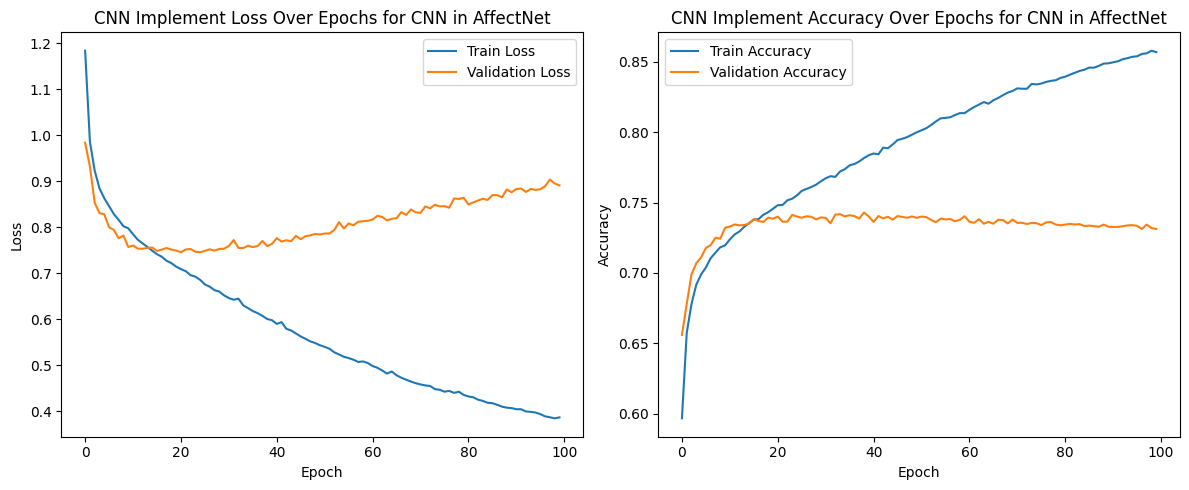

In [5]:
# -------------------------------
# Train the Model (Using Validation Set) and Plot Training History
# -------------------------------
'''history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    shuffle=True,
    validation_data=(X_val, y_val)
)'''
import matplotlib
# Plot Training History: Loss and Accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Implement Loss Over Epochs for CNN in AffectNet')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Implement Accuracy Over Epochs for CNN in AffectNet')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/My Drive/ec523 project/FIGURE_and_TABLE_RESULT/CNN_Implement_Affectnet_loss_and_accuracy_plot.png')
plt.show()
plt.close()

In [6]:
# Evaluate the Model on Test Set and Plot Confusion Matrix
# -------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("CNN Implement Test loss:", test_loss, "CNN Implement Test accuracy:", test_acc)
# Evaluate the Model on Test Set and Plot Confusion Matrix
# -------------------------------
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print("Val Implement loss:", test_loss, "Val Implement accuracy:", test_acc)


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7263 - loss: 0.9021
CNN Implement Test loss: 0.8972700834274292 CNN Implement Test accuracy: 0.7300222516059875
1349/1349 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7348 - loss: 0.8845
Val Implement loss: 0.8972700834274292 Val Implement accuracy: 0.7300222516059875


1349/1349 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


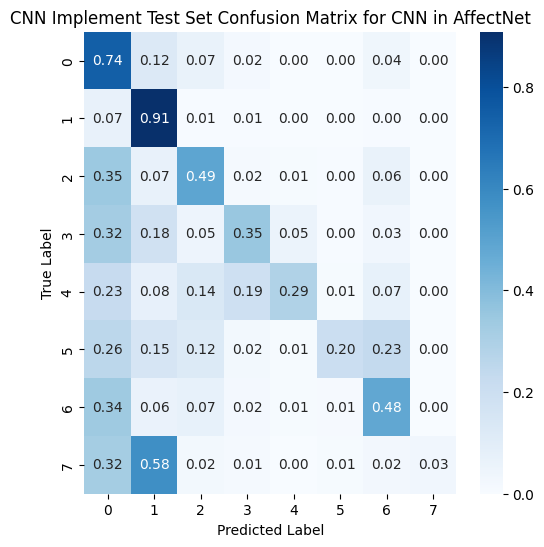

In [7]:
# -------------------------------
# Evaluate the Model on Test Set and Plot Confusion Matrix
# -------------------------------
#test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
#print("Test loss:", test_loss, "Test accuracy:", test_acc)

# Generate Predictions for Confusion Matrix
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_true, y_test_pred_classes, normalize='true')
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')
plt.title("CNN Implement Test Set Confusion Matrix for CNN in AffectNet")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig('/content/drive/My Drive/ec523 project/FIGURE_and_TABLE_RESULT/CNN_Implementation_Affectnet_confusion_matrix.png')
plt.show()
plt.close()

In [8]:
# -------------------------------
# Save the Final Model
# -------------------------------
model.save("/content/drive/My Drive/ec523 project/SAVED_MODEL/CNN_AffectNet_improvement_model.h5")
print("Model saved as CNN_AffectNet_improvement_model.h5")

Model saved as CNN_AffectNet_improvement_model.h5


In [ ]:
u# hypertuning

In [ ]:
# grid search

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'learning_rate': [5e-2, 1e-2, 1e-3],
    'batch_size': [64, 128, 256]
}
grid = list(ParameterGrid(param_grid))
def build_model(learning_rate):
    model = Sequential([
        Input(shape=(48, 48, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same', name="conv1"),
        BatchNormalization(),
        MaxPooling2D(),
        Dropout(0.2),

        Conv2D(32, (3, 3), activation='relu', padding='same', name="conv2"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), name="maxpool2"),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same', name="conv3"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), name="maxpool3"),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same', name="conv4"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), name="maxpool4"),
        Dropout(0.2),

        Conv2D(128, (3, 3), activation='relu', padding='same', name="conv5"),
        BatchNormalization(),
        Dropout(0.3),

        Flatten(),
        Dense(1024, activation='relu', name='fc1'),
        Dropout(0.3),
        BatchNormalization(),

        Dense(NUM_CLASSES, activation='softmax', name='fcsoftmax')
    ])

    optimizer = SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
results = []

for params in grid:
    print(f"Training with params: {params}")

    model = build_model(params['learning_rate'])

    history = model.fit(
        X_train, y_train,
        batch_size=params['batch_size'],
        validation_data=(X_val, y_val),
        epochs=10,
        verbose=0
    )

    val_acc = history.history['val_accuracy'][-1]
    results.append({
        'params': params,
        'val_accuracy': val_acc
    })

Training with params: {'batch_size': 64, 'learning_rate': 0.05}
Training with params: {'batch_size': 64, 'learning_rate': 0.01}
Training with params: {'batch_size': 64, 'learning_rate': 0.001}
Training with params: {'batch_size': 128, 'learning_rate': 0.05}
Training with params: {'batch_size': 128, 'learning_rate': 0.01}
Training with params: {'batch_size': 128, 'learning_rate': 0.001}
Training with params: {'batch_size': 256, 'learning_rate': 0.05}
Training with params: {'batch_size': 256, 'learning_rate': 0.01}
Training with params: {'batch_size': 256, 'learning_rate': 0.001}


In [ ]:
best_result = max(results, key=lambda x: x['val_accuracy'])
print("✅ Best Params:", best_result['params'])
print("✅ Best Val Accuracy:", best_result['val_accuracy'])

✅ Best Params: {'batch_size': 256, 'learning_rate': 0.01}
✅ Best Val Accuracy: 0.7023056149482727
